In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm

from shamans.utils import eval_utils as eval

In [46]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

In [47]:
# load data
exp_id = 1
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

In [48]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)



In [49]:
# n_sources_choice = [1]
# source_type_choices = ['speech']
# snr_choices = np.arange(-30, 31, 10).tolist()
# noise_type_choices = ['awgn', 'alpha-1.2', 'alpha-0.8']
# sound_duration_choices = [0.5]
# add_reverb_choices = [False]

['awgn' 'alpha-1.2' 'alpha-0.8']
noise_type: awgn


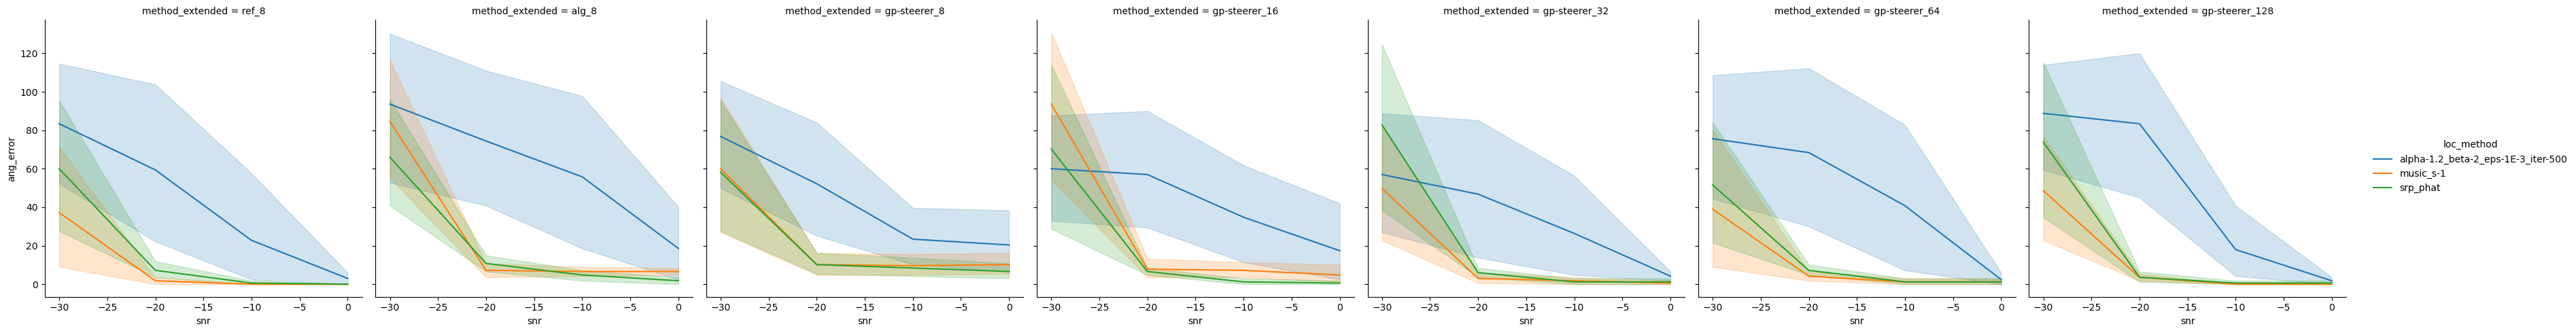

noise_type: alpha-1.2


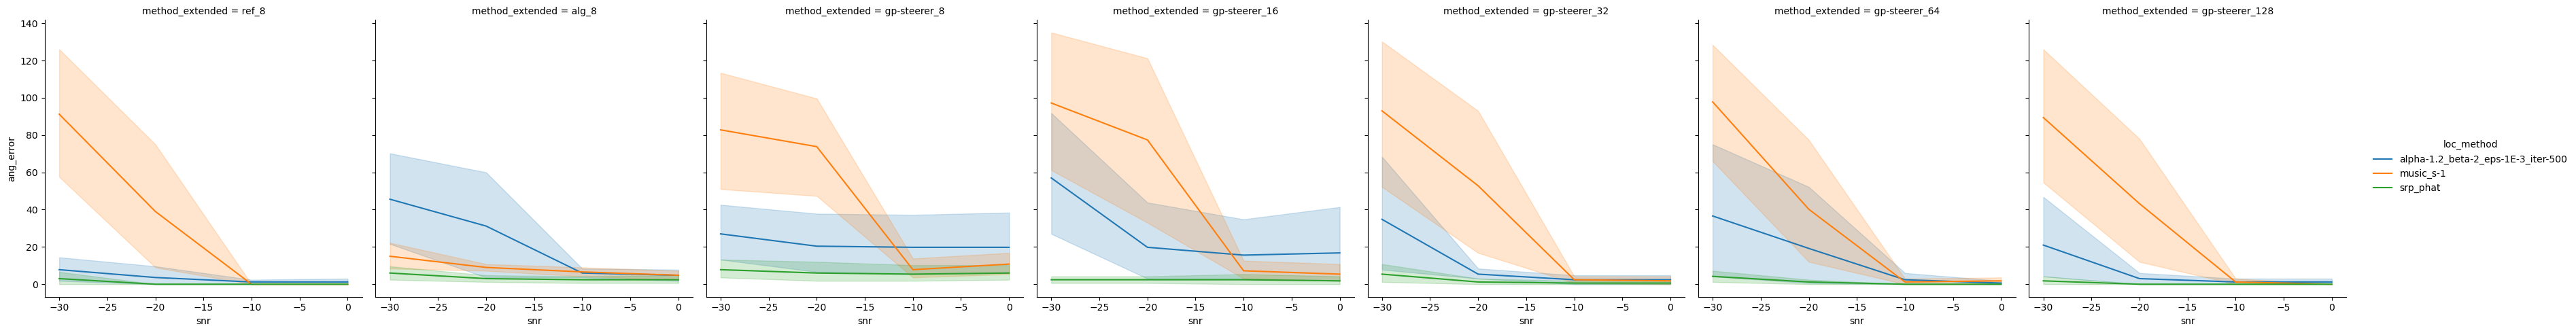

noise_type: alpha-0.8


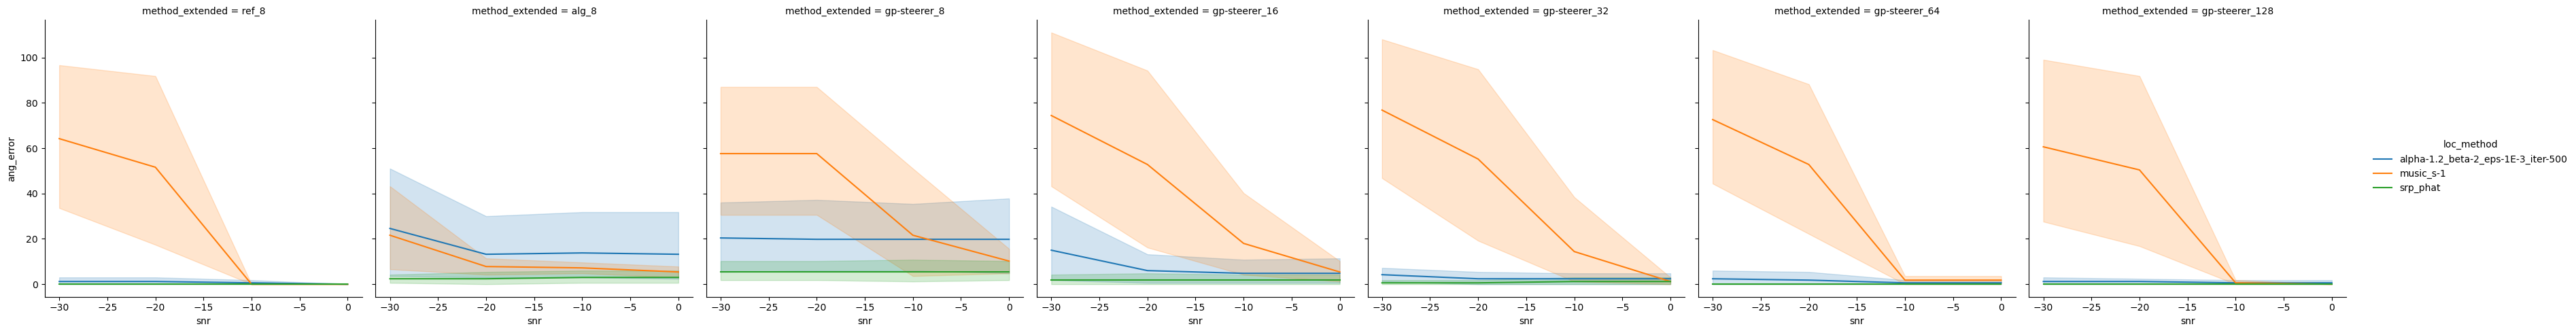

In [50]:
noise_types = exp_df['noise_type'].unique()
print(noise_types)


for noise_type in noise_types:
    
    print(f"noise_type: {noise_type}")
    df_ = exp_df[
        (exp_df['noise_type'] == noise_type)
        & (exp_df['seed'] == 13)
        & (exp_df['snr'] < 10)
    ]
    df_ = df_.assign(method_extended=df_['sv_method'] + '_' + df_['nObs'].astype(str))


    df__ = df_[
        (df_['loc_method'] == 'srp_phat')
        & (df_['method_extended'] == 'ref_8')
    ]
    

    sns.relplot(x='snr', y='ang_error', hue='loc_method', data=df_, kind='line', col='method_extended')
    plt.show()

In [31]:
df__.to_csv('asd.csv', index=False)